# Colorbot

**Special thanks to @MarkDaoust that helped us with this material**

In order to have a better experience follow these steps:

1. Just read all the notebook, try to understand what each part of the code is doing and get familiar with the implementation.
2. For each exercise in this notebook make a copy of this notebook and try to implement what is expected. We suggest the following order for the exercises: HYPERPARAMETERS, EXPERIMENT, DATASET
3. Troubles or doubts about the code/exercises? Ask the instructor about it or check colorbot_solutions.ipnyb for a possible implementation/instruction if available

## Content of this notebook

In this notebook you'll find a full implementation of a RNN model using the TensorFlow Estimators including comments and details about how to do it. 

Once you finish this notebook, you'll have a better understanding of:
  * [TensorFlow Estimators](https://www.tensorflow.org/extend/estimators)
  * [TensorFlow DataSets](https://github.com/tensorflow/tensorflow/tree/r1.2/tensorflow/contrib/data)
  * [RNNs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)


## What is colorbot?

Colorbot is a RNN model that receives a word (sequence of characters) as input and learns to predict a rgb value that better represents this word. As a result we have a color generator!

![colorbot in action](imgs/model_gif.gif)

## Dependencies

In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Tensorflow
import tensorflow as tf
print('Use TensorFlow v1.2 or higher')
print('Your TensorFlow version:', tf.__version__) 

# Feeding function for enqueue data
from tensorflow.python.estimator.inputs.queues import feeding_functions as ff

# Rnn common functions
from tensorflow.contrib.learn.python.learn.estimators import rnn_common

# Run an experiment
from tensorflow.contrib.learn.python.learn import learn_runner

# Model builder
from tensorflow.python.estimator import model_fn as model_fn_lib

# Plot images with pyplot
%matplotlib inline
from matplotlib import pyplot as plt

# Helpers for data processing
import pandas as pd
import numpy as np
import argparse

Use TensorFlow v1.2 or higher
Your TensorFlow version: 1.2.0


## Parameters

In [27]:
# Data files
TRAIN_INPUT = 'data/train.csv'
TEST_INPUT = 'data/test.csv'
MY_TEST_INPUT = 'data/mytest.csv'

# Parameters for training
BATCH_SIZE = 64

# Parameters for data processing
VOCAB_SIZE = 256
CHARACTERS = [chr(i) for i in range(VOCAB_SIZE)]
SEQUENCE_LENGTH_KEY = 'sequence_length'
COLOR_NAME_KEY = 'color_name'

## Helper functions

In [28]:
# Returns the column values from a CSV file as a list
def _get_csv_column(csv_file, column_name):
    with open(csv_file, 'r') as f:
        df = pd.read_csv(f)
        return df[column_name].tolist()

# Plots a color image
def _plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

## Input function

Here we are defining the input pipeline using the [Dataset API](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/data).

One special operation that we're doing is called **group_by_window**, what this function does is to map each consecutive element in this dataset to a key using `key_func` and then groups the elements by key. It then applies `reduce_func` to at most `window_size` elements matching the same key. All except the final window for each key will contain `window_size` elements; the final window may be smaller.

In the code below what we're doing is using the group_by_window to batch color names that have similar length together, this makes the code more efficient since the RNN will be unfolded (approximately) the same number of steps in each batch.

![](imgs/batch_by_length.png)
*Image from [Sequence Models and the RNN API (TensorFlow Dev Summit 2017)](https://www.youtube.com/watch?v=RIR_-Xlbp7s)*

** *EXERCISE DATASET (first complete the EXERCISE EXPERIMENT: change the input function bellow so it will just use normal padded_batch instead sorting the batches. Then run each model using experiments and compare the efficiency (time, global_step/sec) using TensorBoard.
hint: to compare the implementations using tensorboard just copy the model_dir folder of both executions to the same directory (the model dir should be different at each time you run the model) and point tensorboard to it with: tensorboard --logdir=path_to_model_dirs_par)* **

In [29]:
def get_input_fn(csv_file, batch_size, num_epochs=1, shuffle=True):
    def _parse(line):
        '''
            This function will parse each line of the text,
            returning 3 variables.
            
            Each line contains: name, red, green, blue separated by ","
            Where:
                name: string
                red, green, blue: int [0, 255]
    
            The variables returned are:
                color: tensor containing the rgb values normalized that represent the color name.
                Each rgb values is an int [0, 1].
                
                color_name: a sequence of characters. Example: if name is "blue"
                color_name will be ["b", "l", "u", "e"]
                
                length = len(color_name). Example: if color_name = ["b", "l", "u", "e"], then length = 4 
        '''
    
        # split line
        items = tf.string_split([line],',').values

        # get 3 last values in the line that are the color rgb values
        color = tf.string_to_number(items[1:], out_type=tf.float32) / 255.0

        # split color_name (first value in the line)
        # into a sequence of characters and calculates the length
        color_name = tf.string_split([items[0]], '')
        length = color_name.indices[-1, 1] + 1 # length = index of last char + 1
        color_name = color_name.values
        
        return color, color_name, length

    def _length_bin(length, cast_value=5, max_bin_id=10):
        '''
        Chooses a bin for a word given it's length.
        The goal is to use group_by_window to group words
        with the ~ same ~ length in the same bin.

        Each bin will have the size of a batch, so it can train faster.
        '''
        bin_id = tf.cast(length / cast_value, dtype=tf.int64)
        return tf.minimum(bin_id, max_bin_id)

    def _pad_batch(ds, batch_size):
        return ds.padded_batch(batch_size, 
                               padded_shapes=([None], [None], []),
                               padding_values=(0.0, chr(0), tf.cast(0, tf.int64)))

    def input_fn():
        # https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/data
        dataset = (
            tf.contrib.data.TextLineDataset(csv_file) # reading from the HD
            .skip(1) # skip header
            .repeat(num_epochs) # repeat dataset the number of epochs
            .map(_parse) # parse each line of text to variables
            .group_by_window(key_func=lambda color, color_name, length: _length_bin(length), # choose a bin
                             reduce_func=lambda key, ds: _pad_batch(ds, batch_size), # apply reduce funtion
                             window_size=batch_size)
        )
        
        # for our "manual" test we don't want to shuffle the data
        if shuffle:
            dataset = dataset.shuffle(buffer_size=100000)

        # create iterator
        color, color_name, length = dataset.make_one_shot_iterator().get_next()

        features = {
            COLOR_NAME_KEY: color_name,
            SEQUENCE_LENGTH_KEY: length,
        }

        return features, color
    return input_fn

In [30]:
train_input_fn = get_input_fn(TRAIN_INPUT, BATCH_SIZE)
test_input_fn = get_input_fn(TEST_INPUT, BATCH_SIZE)

## Creating the Estimator model

![](imgs/colorbot_model.png)

In [45]:
def get_model_fn(rnn_cell_sizes,
                 label_dimension,
                 dnn_layer_sizes=[],
                 optimizer='SGD',
                 learning_rate=0.01):
    
    def model_fn(features, labels, mode):
        
        color_name = features[COLOR_NAME_KEY]
        sequence_length = tf.cast(features[SEQUENCE_LENGTH_KEY], dtype=tf.int32) # int64 -> int32
        
        # ----------- Preparing input --------------------
        # Creating a tf constant to hold the characters used in the data
        mapping = tf.constant(CHARACTERS, name="mapping")
        table = tf.contrib.lookup.index_table_from_tensor(mapping, dtype=tf.string)
        int_color_name = table.lookup(color_name)
        
        # converting color names to one hot representation
        color_name_onehot = tf.one_hot(int_color_name, depth=len(CHARACTERS) + 1)
        
        # ---------- RNN -------------------
        # Each RNN layer will consist of a LSTM cell
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in rnn_cell_sizes]
        
        # Construct the layers
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        
        # Runs the RNN model dynamically
        # more about it at: 
        # https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
        outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                                 inputs=color_name_onehot,
                                                 sequence_length=sequence_length,
                                                 dtype=tf.float32)

        # Slice to keep only the last cell of the RNN
        last_activations = rnn_common.select_last_activations(outputs,
                                                              sequence_length)

        # ------------ Dense layers -------------------
        # Construct dense layers on top of the last cell of the RNN
        for units in dnn_layer_sizes:
            last_activations = tf.layers.dense(
              last_activations, units, activation=tf.nn.relu)
        
        # Final dense layer for prediction
        predictions = tf.layers.dense(last_activations, label_dimension)

        # ----------- Loss and Optimizer ----------------
        loss = None
        train_op = None

        if mode != tf.estimator.ModeKeys.PREDICT:    
            loss = tf.losses.mean_squared_error(labels, predictions)
    
        if mode == tf.estimator.ModeKeys.TRAIN:    
            train_op = tf.contrib.layers.optimize_loss(
              loss,
              tf.contrib.framework.get_global_step(),
              optimizer=optimizer,
              learning_rate=learning_rate)
        
        return model_fn_lib.EstimatorSpec(mode,
                                           predictions=predictions,
                                           loss=loss,
                                           train_op=train_op)
    return model_fn

** *EXERCISE HYPERPARAMETERS: try making changes to the model and see if you can improve the results.
Run the original model, run yours and compare them using Tensorboard. What improvements do you see?  
hint 0: change the type of RNNCell, maybe a GRUCell? Change the number of hidden layers, or add dnn layers.  
hint 1: to compare the implementations using tensorboard just copy the model_dir folder of both executions to the same directory (the model dir should be different at each time you run the model) and point tensorboard to it with: tensorboard --logdir=path_to_model_dirs_par)* **

In [47]:
model_fn = get_model_fn(rnn_cell_sizes=[256, 128], # size of the hidden layers
                        label_dimension=3, # since is RGB
                        dnn_layer_sizes=[128], # size of units in the dense layers on top of the RNN
                        optimizer='Adam', # changing optimizer to Adam
                        learning_rate=0.01)

estimator = tf.estimator.Estimator(model_fn=model_fn, model_dir='colorbot')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_model_dir': 'colorbot', '_save_summary_steps': 100}


## Trainning and Evaluating

** *EXERCISE EXPERIMENT: The code below works, but we can use an experiment instead. Add a cell that runs an experiment instead of interacting directly with the estimator.  
hint 0: you'll need to change the train_input_fn definition, think about it...  
hint 1: the change is related with the for loop* **

In [36]:
NUM_EPOCHS = 40
for i in range(NUM_EPOCHS):
    print('Training epoch %d' % i)
    print('-' * 20)
    estimator.train(input_fn=train_input_fn)
    print('Evaluating epoch %d' % i)
    print('-' * 20)
    estimator.evaluate(input_fn = test_input_fn)

Training epoch 0
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-1381
INFO:tensorflow:Saving checkpoints for 1382 into colorbot/model.ckpt.
INFO:tensorflow:loss = 0.0165094, step = 1382
INFO:tensorflow:Saving checkpoints for 1404 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00569388.
Evaluating epoch 0
--------------------
INFO:tensorflow:Starting evaluation at 2017-07-08-22:38:42
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-1404
INFO:tensorflow:Finished evaluation at 2017-07-08-22:38:42
INFO:tensorflow:Saving dict for global step 1404: global_step = 1404, loss = 0.0637945
Training epoch 1
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-1404
INFO:tensorflow:Saving checkpoints for 1405 into colorbot/model.ckpt.
INFO:tensorflow:loss = 0.0158734, step = 1405
INFO:tensorflow:Saving checkpoints for 

INFO:tensorflow:Finished evaluation at 2017-07-08-22:39:42
INFO:tensorflow:Saving dict for global step 1657: global_step = 1657, loss = 0.0679379
Training epoch 12
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-1657
INFO:tensorflow:Saving checkpoints for 1658 into colorbot/model.ckpt.
INFO:tensorflow:loss = 0.0180977, step = 1658
INFO:tensorflow:Saving checkpoints for 1680 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00222656.
Evaluating epoch 12
--------------------
INFO:tensorflow:Starting evaluation at 2017-07-08-22:39:46
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-1680
INFO:tensorflow:Finished evaluation at 2017-07-08-22:39:47
INFO:tensorflow:Saving dict for global step 1680: global_step = 1680, loss = 0.0824235
Training epoch 13
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-1680
INFO:t

Evaluating epoch 23
--------------------
INFO:tensorflow:Starting evaluation at 2017-07-08-22:40:53
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-1933
INFO:tensorflow:Finished evaluation at 2017-07-08-22:40:54
INFO:tensorflow:Saving dict for global step 1933: global_step = 1933, loss = 0.0826303
Training epoch 24
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-1933
INFO:tensorflow:Saving checkpoints for 1934 into colorbot/model.ckpt.
INFO:tensorflow:loss = 0.0840174, step = 1934
INFO:tensorflow:Saving checkpoints for 1956 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0219377.
Evaluating epoch 24
--------------------
INFO:tensorflow:Starting evaluation at 2017-07-08-22:41:00
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-1956
INFO:tensorflow:Finished evaluation at 2017-07-08-22:41:00
INFO:tensorflow:Saving dict for global step 1956: global_step = 1956, loss = 

INFO:tensorflow:loss = 0.0471903, step = 2187
INFO:tensorflow:Saving checkpoints for 2209 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00313982.
Evaluating epoch 35
--------------------
INFO:tensorflow:Starting evaluation at 2017-07-08-22:42:14
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-2209
INFO:tensorflow:Finished evaluation at 2017-07-08-22:42:14
INFO:tensorflow:Saving dict for global step 2209: global_step = 2209, loss = 0.0879443
Training epoch 36
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-2209
INFO:tensorflow:Saving checkpoints for 2210 into colorbot/model.ckpt.
INFO:tensorflow:loss = 0.0427003, step = 2210
INFO:tensorflow:Saving checkpoints for 2232 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.000384435.
Evaluating epoch 36
--------------------
INFO:tensorflow:Starting evaluation at 2017-07-08-22:42:19
INFO:tensorflow:Restoring parameters

## Making Predictions

In [37]:
def predict(estimator, input_file):
    preds = estimator.predict(input_fn=get_input_fn(input_file, 1, shuffle=False))
    color_names = _get_csv_column(input_file, 'name')

    print()
    for p, name in zip(preds, color_names):
        color = tuple(map(int, p * 255))
        print(name + ',', 'rgb:', color)
        _plot_rgb(p)


INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-2301
orange, rgb: (219, 68, 53)


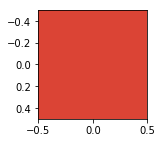

tensorflow orange, rgb: (242, 115, 18)


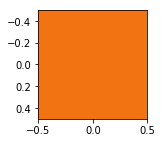

adfgasdgasd, rgb: (135, 181, 185)


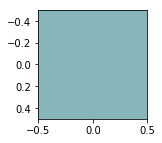

purple blue, rgb: (56, 140, 191)


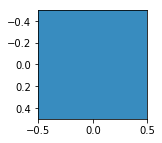

purple red, rgb: (192, 26, 51)


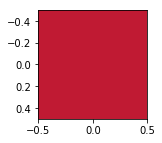

purple, rgb: (80, 61, 118)


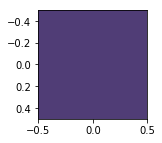

water, rgb: (186, 113, 65)


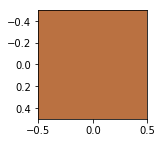

pink, rgb: (238, 189, 224)


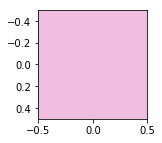

rock, rgb: (170, 85, 92)


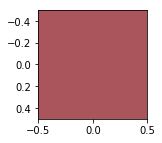

In [40]:
predict(estimator, MY_TEST_INPUT)

## Pre-trained model predictions

In order to load the pre-trained model we can just create an estimator using the model_fn and use the model_dir that contains the pre-trained model files in this case it's 'pretrained'

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_model_dir': 'pretrained', '_save_summary_steps': 100}

INFO:tensorflow:Restoring parameters from pretrained/model.ckpt-8069
orange, rgb: (233, 124, 19)


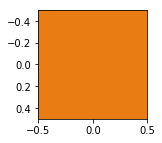

tensorflow orange, rgb: (232, 149, 88)


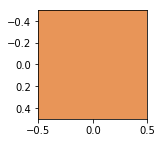

adfgasdgasd, rgb: (201, 184, 157)


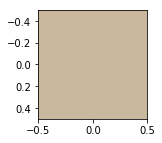

purple blue, rgb: (51, 13, 220)


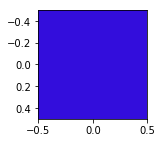

purple red, rgb: (152, 40, 61)


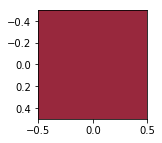

purple, rgb: (92, 23, 109)


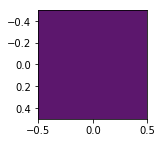

water, rgb: (160, 201, 202)


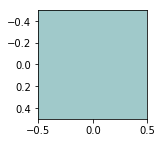

pink, rgb: (257, 153, 165)


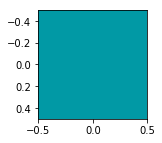

rock, rgb: (83, 65, 52)


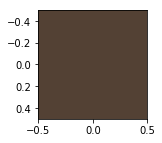

In [48]:
pre_estimator = tf.estimator.Estimator(model_dir='pretrained', model_fn=model_fn)
predict(pre_estimator, MY_TEST_INPUT)